# Planning an observing run
In this module, we will look at how to plan observations, select targets, get visibility and airmass plots, moon separation angles, exposure time considerations etc.

In [1]:
import numpy as np
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
import pytz
%matplotlib inline
from astroplan import Observer, FixedTarget

### Date and Time
- Dates and times are in UTC
- Default time is 00:00:00 UTC (verify this)

In [2]:
date = Time("2018-12-03", format='iso')
print(date)

2018-12-03 00:00:00.000


### What is the current UTC?

In [3]:
now = Time.now()
print(now)
print(now.jd)
print(now.mjd)
print(now.decimalyear)

2018-11-30 11:36:39.205721
2458452.983787103
58452.48378710325
2018.9136542112417


In [4]:
#What time will it be (in UTC) after 1 hour 45 minutes from now? Complete the line below to print it out.
#print("In 1 hour and 45 minutes, the time will be {0} UTC".format())

### Using UT1
- To keep accurate time, the changes in earth's rotation period have to be taken into account.
- AstroPy does this using a convention called UT1, that is tied to the rotation of earth with respect to the position of distant quasars. IERS - International Earth Rotation and Reference Systems Service keeps continuous tabs on the orientation of the earth and updates the data in the IERS bulletin.
Update the bulletin:

In [5]:
from astroplan import download_IERS_A 
download_IERS_A()

### Check to see what observatories are available in the database.

In [6]:
print("Available observatories: \n{0}"
      .format(', '.join(EarthLocation.get_site_names())))

Available observatories: 
, , , ALMA, Anglo-Australian Observatory, Apache Point, Apache Point Observatory, Atacama Large Millimeter Array, BAO, Beijing XingLong Observatory, Black Moshannon Observatory, CHARA, Canada-France-Hawaii Telescope, Catalina Observatory, Cerro Pachon, Cerro Paranal, Cerro Tololo, Cerro Tololo Interamerican Observatory, DCT, Discovery Channel Telescope, Dominion Astrophysical Observatory, GBT, Gemini South, Green Bank Telescope, Hale Telescope, Haleakala Observatories, Happy Jack, JCMT, James Clerk Maxwell Telescope, Jansky Very Large Array, Keck Observatory, Kitt Peak, Kitt Peak National Observatory, La Silla Observatory, Large Binocular Telescope, Las Campanas Observatory, Lick Observatory, Lowell Observatory, MWA, Manastash Ridge Observatory, McDonald Observatory, Medicina, Medicina Dish, Michigan-Dartmouth-MIT Observatory, Mount Graham International Observatory, Mt Graham, Mt. Ekar 182 cm. Telescope, Mt. Stromlo Observatory, Multiple Mirror Telescope, Murc

### Setting up observatory location

In [7]:
#IAO is not listed in the database, so let's define the location
longitude = '78d57m53s'
latitude = '32d46m44s'
elevation = 4500 * u.m
location = EarthLocation.from_geodetic(longitude, latitude, elevation)
iaohanle = Observer(location = location, timezone = 'Asia/Kolkata',
                             name = "IAO", description = "GROWTH-India 70cm telescope")
iaohanle

<Observer: name='IAO',
    location (lon, lat, el)=(78.96472222222222 deg, 32.77888888888889 deg, 4499.999999999798 m),
    timezone=<DstTzInfo 'Asia/Kolkata' LMT+5:53:00 STD>>

### Sunset, Sunrise, Midnight

In [8]:
#Calculating the sunset, midnight and sunrise times for our observatory 
#What is astronomical twilight?
sunset_iao = iaohanle.sun_set_time(now, which='nearest')
eve_twil_iao = iaohanle.twilight_evening_astronomical(now, which='nearest')
midnight_iao = iaohanle.midnight(now, which='next')
morn_twil_iao = iaohanle.twilight_morning_astronomical(now, which='next')
sunrise_iao = iaohanle.sun_rise_time(now, which='next')

print("Sunset at IAO will be at {0.iso} UTC".format(sunset_iao))
print("Astronomical evening twilight at IAO will be at {0.iso} UTC".format(eve_twil_iao))
print("Midnight at IAO will be at {0.iso} UTC".format(midnight_iao))
print("Astronomical morning twilight at IAO will be at {0.iso} UTC".format(morn_twil_iao))
print("Sunrise at IAO will be at {0.iso} UTC".format(sunrise_iao))


Sunset at IAO will be at 2018-11-30 11:33:26.114 UTC
Astronomical evening twilight at IAO will be at 2018-11-30 13:04:50.998 UTC
Midnight at IAO will be at 2018-11-30 18:32:53.173 UTC
Astronomical morning twilight at IAO will be at 2018-12-01 00:01:03.361 UTC
Sunrise at IAO will be at 2018-12-01 01:32:35.334 UTC


### Exercise 
Find the effective length of time (in hours) available for astronomical observations at IAO tonight

In [9]:
observing_time = (morn_twil_iao - eve_twil_iao).to(u.h)
print("You can observe for {0:.1f} at IAO tonight".format(observing_time))

You can observe for 10.9 h at IAO tonight


### Local Sidereal Time (LST)

In [10]:
#What is the LST now at IAO Hanle?
#What would the LST be at IAO at local midnight?
lst_now = iaohanle.local_sidereal_time(now)
lst_mid = iaohanle.local_sidereal_time(midnight_iao)
print("LST at IAO now is {0:.2f}".format(lst_now))
print("LST at IAO at local midnight will be {0:.2f}".format(lst_mid))

LST at IAO now is 21.49 hourangle
LST at IAO at local midnight will be 4.45 hourangle


### Choosing targets for observations
Targets can be defined by name or coordinates.


In [11]:
coords = SkyCoord('00h42m41.8s', '+40d51m55.0s', frame='icrs') # coordinates of Andromeda Galaxy (M32) 
m32 = FixedTarget(name = 'M32', coord=coords)
m32.ra.hms

hms_tuple(h=0.0, m=42.0, s=41.799999999999926)

In [12]:
#Check to see if target is up at evening twilight.
#Also check if target is available at midnight and morning twilight.

iaohanle.target_is_up(eve_twil_iao, m32)
#iaohanle.target_is_up()
#iaohanle.target_is_up()

True

In [13]:
#Altitude and Azimuth of target
aa = iaohanle.altaz(midnight_iao, m32)
aa.alt.degree, aa.az.degree

(45.35947757187762, 297.2448430269061)

Checking rise times of targets

In [14]:
m32rise = iaohanle.target_rise_time(now, m32, which = 'next', horizon = 0 * u.deg)
print(m32rise.iso)  #default format is JD

2018-12-01 06:31:34.164


### Defining targets by name

In [15]:
target = FixedTarget.from_name('m33') #M33 triangulum galaxy
target.coord

<SkyCoord (ICRS): (ra, dec) in deg
    ( 23.4621,  30.6599417)>

### Dealing with moving targets

In [16]:
from astropy.coordinates import get_sun, get_moon, get_body
from astroplan import moon_illumination
get_body('jupiter', now)

<SkyCoord (GCRS: obstime=2018-11-30 11:36:39.205721, obsgeoloc=( 0.,  0.,  0.) m, obsgeovel=( 0.,  0.,  0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    ( 242.78389223, -20.41822486,  6.34289914)>

In [17]:
#get moon position at midnight 
get_moon(midnight_iao)

<SkyCoord (GCRS: obstime=2458453.272837651, obsgeoloc=( 0.,  0.,  0.) m, obsgeovel=( 0.,  0.,  0.) m / s): (ra, dec, distance) in (deg, deg, km)
    ( 170.58741323,  8.35959539,  373599.03622182)>

In [18]:
#How bright is the moon at midnight?
moon_illumination(midnight_iao)

0.4160534121219185

In [19]:
#We can turn solar system objects into 'pseudo-fixed' targets to plan observations
saturn_midnight = FixedTarget(name = 'Saturn', coord = get_body('saturn', midnight_iao))
saturn_midnight.coord

<SkyCoord (GCRS: obstime=2458453.272837651, obsgeoloc=( 0.,  0.,  0.) m, obsgeovel=( 0.,  0.,  0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    ( 278.17560099, -22.69595989,  10.91031882)>

### Airmass
- Ideally, targets should be observed when they have the least airmass. Airmass ranges from 1 (zenith) to ~38 at the horizon.
- Airmass is 2.0 at alt=30, 2.9 at alt=20 and 3.9 at alt=15 degrees
- As a general rule of thumb, try observing targets when airmass > 2
- Let us find the airmass of M33 at midnight at IAO

In [20]:
#Is the target up at IAO at midnight?
iaohanle.target_is_up(midnight_iao, target)

True

In [21]:
#lets check the alt and az of the target at midnight
target_altaz = iaohanle.altaz(midnight_iao, target)
target_altaz.altaz

<SkyCoord (AltAz: obstime=2458453.272837651, location=(1028191.0351614766, 5272251.018029276, 3435803.525674053) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0, obswl=1.0 micron): (az, alt) in deg
    ( 278.71488331,  53.60940062)>

That's a good enough elevation to observe the target.

In [22]:
#Find the airmass
target_altaz.secz

<Quantity 1.2422496822178843>

Now we can visualize what we have done so far using some plots

In [23]:
import matplotlib.pyplot as plt
from astroplan.plots import plot_sky, plot_airmass

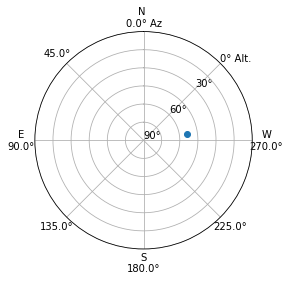

In [24]:
#position of target at midnight
plot_sky(target, iaohanle, midnight_iao)

Now let us see how the target moves over the course of the night

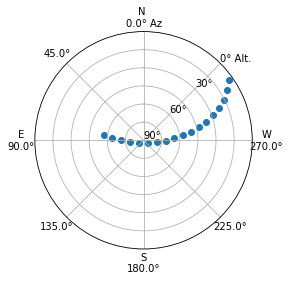

In [25]:
t_start = eve_twil_iao
t_end = morn_twil_iao
t_observe = t_start + (t_end - t_start) * np.linspace(0.0, 1.0, 20)
plot_sky(target, iaohanle, t_observe)

Now let's plot the airmass as a function of time

(4, 0.5)

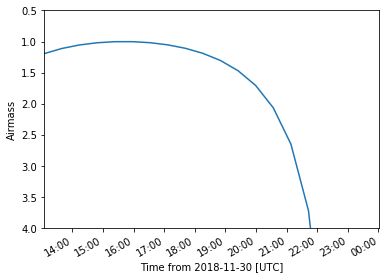

In [26]:
plot_airmass(target, iaohanle, t_observe)
plt.ylim(4,0.5)

The airmass is above 2 for the better part of the night, making M33 a good target to observe from IAO tonight.
Note that the default airmass limit is 3 in astroplan, corresponding to ~19 degrees elevation.

### Finder Charts

In [27]:
from astroplan.plots import plot_finder_image
from astroquery.skyview import SkyView

(<matplotlib.axes._subplots.WCSAxesSubplot at 0x7f78aab6dac8>,
 <astropy.io.fits.hdu.image.PrimaryHDU at 0x7f78aab61eb8>)

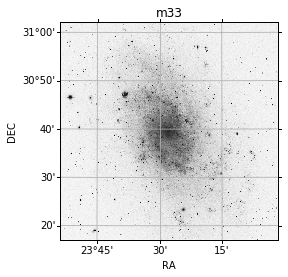

In [28]:
plot_finder_image(target, fov_radius = 45 * u.arcmin)  #field of view corresponding to the GROWTH-India telesocpe

Now let's define an array of targets to work with

In [29]:
target_names = ['vega', 'polaris', 'm1', 'm42', 'm55']
targets = [FixedTarget.from_name(target) for target in target_names]
targets

[<FixedTarget "vega" at SkyCoord (ICRS): (ra, dec) in deg ( 279.23473479,  38.78368896)>,
 <FixedTarget "polaris" at SkyCoord (ICRS): (ra, dec) in deg ( 37.95456067,  89.26410897)>,
 <FixedTarget "m1" at SkyCoord (ICRS): (ra, dec) in deg ( 83.633083,  22.0145)>,
 <FixedTarget "m42" at SkyCoord (ICRS): (ra, dec) in deg ( 83.82208, -5.39111)>,
 <FixedTarget "m55" at SkyCoord (ICRS): (ra, dec) in deg ( 294.998792, -30.96475)>]

Which of these targets is up now?

In [30]:
iaohanle.target_is_up(now, targets)

array([ True,  True, False, False,  True], dtype=bool)

In [31]:
iaohanle.target_is_up(eve_twil_iao, targets)

array([ True,  True,  True, False,  True], dtype=bool)

### Exercise
Find out the times at which the targets rise to an elevation of 10 degrees. Use target_rise_time. 

In [32]:
for target in targets:
    print(iaohanle.target_rise_time(now, target, which = 'next', horizon = 10*u.deg).iso)    

2018-12-01 01:43:36.233
-4715-02-28 12:00:00.000


2018-11-30 13:33:40.933
2018-11-30 14:44:53.509
2018-12-01 06:20:13.918


What is the elevation of Vega now?

In [33]:
iaohanle.altaz(now, targets[0])

<SkyCoord (AltAz: obstime=2018-11-30 11:36:39.205721, location=(1028191.0351614766, 5272251.018029276, 3435803.525674053) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0, obswl=1.0 micron): (az, alt) in deg
    ( 292.33423858,  54.90275609)>

Now let's plot the elevation of Vega to see how it varies over the night

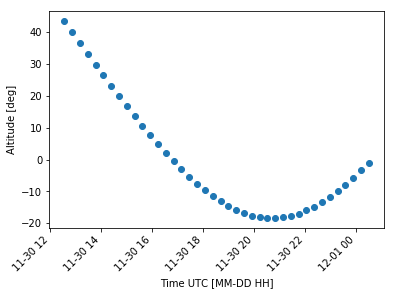

In [34]:
times = (t_start - 0.5 * u.h) + (t_end - t_start + 1 * u.h) * np.linspace(0.0, 1.0, 40)
elevations = iaohanle.altaz(times, targets[0]).alt
ax = plt.gca()
ax.plot_date(times.plot_date, elevations.deg)
ax.set(xlabel = 'Time UTC [MM-DD HH]' ,ylabel = 'Altitude [deg]')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

### Exercise
Plot the altitude as a function of time for tonight for each of the targets in a single plot

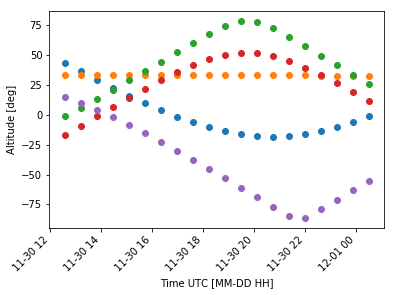

In [35]:
times = (t_start - 0.5 * u.h) + (t_end - t_start + 1 * u.h) * np.linspace(0.0, 1.0, 20)
elevations = []
for target in targets: 
    elevations.append(iaohanle.altaz(times, target).alt)
    
ax = plt.gca()
for elevation in elevations:
    ax.plot_date(times.plot_date, elevation)
    
ax.set(xlabel = 'Time UTC [MM-DD HH]' ,ylabel = 'Altitude [deg]')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.legend()

### Exercise
Plot sky positions for each target using plot_sky for tonight at IAO in a single plot.

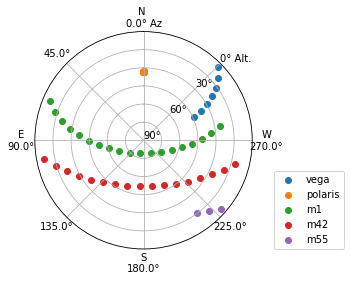

In [36]:
times = (t_start - 0.5 * u.h) + (t_end - t_start + 1 * u.h) * np.linspace(0.0, 1.0, 20)
for target in targets:
    plot_sky(target, iaohanle, times)
plt.legend(loc=[1.1,0])

### Exercise
Plot airmass vs time for each target in targets for tonight at IAO.

### Observational Constraints
- between civil twilights
- airmass
- altitude limits

In [86]:
from astroplan import (AltitudeConstraint, AirmassConstraint,
                       AtNightConstraint, MoonSeparationConstraint)
constraints = [AltitudeConstraint(15*u.deg, 84*u.deg),
               AirmassConstraint(5), AtNightConstraint.twilight_civil(), MoonSeparationConstraint(min = 10 * u.deg)]
t_range = Time([t_start - 0.5 * u.hour, t_end + 0.5 * u.hour])

In [87]:
from astroplan import is_observable, is_always_observable, months_observable
# Are targets ever observable in the time range?
ever_observable = is_observable(constraints, iaohanle, targets, time_range=t_range)
print(ever_observable)
# Are targets always observable in the time range?
always_observable = is_always_observable(constraints, iaohanle, targets, time_range=t_range)
print(always_observable)
# During what months are the targets ever observable?
obs_months = months_observable(constraints, iaohanle, targets)

[ True  True  True  True  True]
[False  True False False False]


The functions is_observable and ever_observable return boolean arrays. Let's print their output in tabular form.

In [88]:
from astropy.table import Table
observability_table = Table()
observability_table['targets'] = [target.name for target in targets]
observability_table['ever_observable'] = ever_observable
observability_table['always_observable'] = always_observable
print(observability_table)

targets ever_observable always_observable
------- --------------- -----------------
   vega            True             False
polaris            True              True
     m1            True             False
    m42            True             False
    m55            True             False


Or we could do this directly using the observability_table function 

In [89]:
from astroplan import observability_table
table = observability_table(constraints, iaohanle, targets, time_range = t_range)
print(table)

target name ever observable always observable fraction of time observable
----------- --------------- ----------------- ---------------------------
       vega            True             False                        0.25
    polaris            True              True                         1.0
         m1            True             False                       0.875
        m42            True             False                        0.75
        m55            True             False             0.0416666666667


### Exercise
- Create a list of your favourite targets and store it in a text file with 3 columns - name, RA and Dec. Or you could    use 'targetlists.txt' which already contains a list of targets. 
- Read the text file, and store the targets as FixedTarget objects.
- Get observability tables for all the targets for different moon separation angles (10, 20, 30... degrees)
- Plot airmass and sky position as a function of time for tonight for all your targets.